In [10]:
# Importing necessary libraries
from os import path
from ydata_synthetic.synthesizers.timeseries import TimeSeriesSynthesizer
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Define Model hyperparameters

**Networks:**
- Generator
- Discriminator
- Embedder
- Recovery Network

TimeGAN is a Generative model based on RNN networks. In this package the implemented version follows a very simple architecture that is shared by the four elements of the GAN.

Similarly to other parameters, the architectures of each element should be optimized and tailored to the data.

In [11]:
#Specific to TimeGANs
gan_args = ModelParameters(batch_size=64,
                           lr=5e-4,
                           noise_dim=32,
                           layers_dim=128,
                           latent_dim=24,
                           gamma=0.8)

train_args = TrainParameters(epochs=100,
                             sequence_length=100, # timesteps
                             number_sequences=8)  # no of features

## The data

In [12]:
# load true positive samples
all_label = pd.read_csv(f'../lalamove/lalamove/data/Clean_5s_half_sec/train/6/train_label_6.csv')
scaler = pd.read_csv(f'../lalamove/lalamove/data/Clean_5s_half_sec/data_scaler.csv')

true_positive_idx = all_label[all_label.label == 1]
true_positive_samples = []
for t in true_positive_idx.timestamp:
    x = np.load(f'../lalamove/lalamove/data/Clean_5s_half_sec/train/6/{t}.npy', allow_pickle=True)
    x = (x  - scaler['mean_val'].values.reshape(1, -1)) / scaler['std_val'].values.reshape(1, -1)
    true_positive_samples.append(x)

n = len(true_positive_samples)
true_positive_samples = np.asarray(true_positive_samples)
true_positive_samples = pd.DataFrame(true_positive_samples.reshape(-1, true_positive_samples.shape[-1]), columns=['x_gyro_clean', 'y_gyro_clean', 'z_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'speed_kmh', 'acceleration'])
print(n, true_positive_samples.shape)

224 (22400, 8)


## Training the TimeGAN synthetizer

In [13]:
# if path.exists('synthesizer_stock.pkl'):
#     synth = TimeSeriesSynthesizer.load('synthesizer_stock.pkl')
# else:
synth = TimeSeriesSynthesizer(modelname='timegan', model_parameters=gan_args)
synth.fit(true_positive_samples, train_args, num_cols=list(true_positive_samples.columns))
synth.save('synthesizer_stock.pkl')

A DataProcessor is not available for the TimeGAN.


Joint networks training: 100%|██████████| 100/100 [10:23<00:00,  6.24s/it]
c:\Users\tmhnguyen\Anaconda3\envs\learning\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### The generated synthetic stock data

In [14]:
new_sample = synth.sample(n_samples=n)

(100, 8) <class 'pandas.core.frame.DataFrame'> 224
(100, 8)


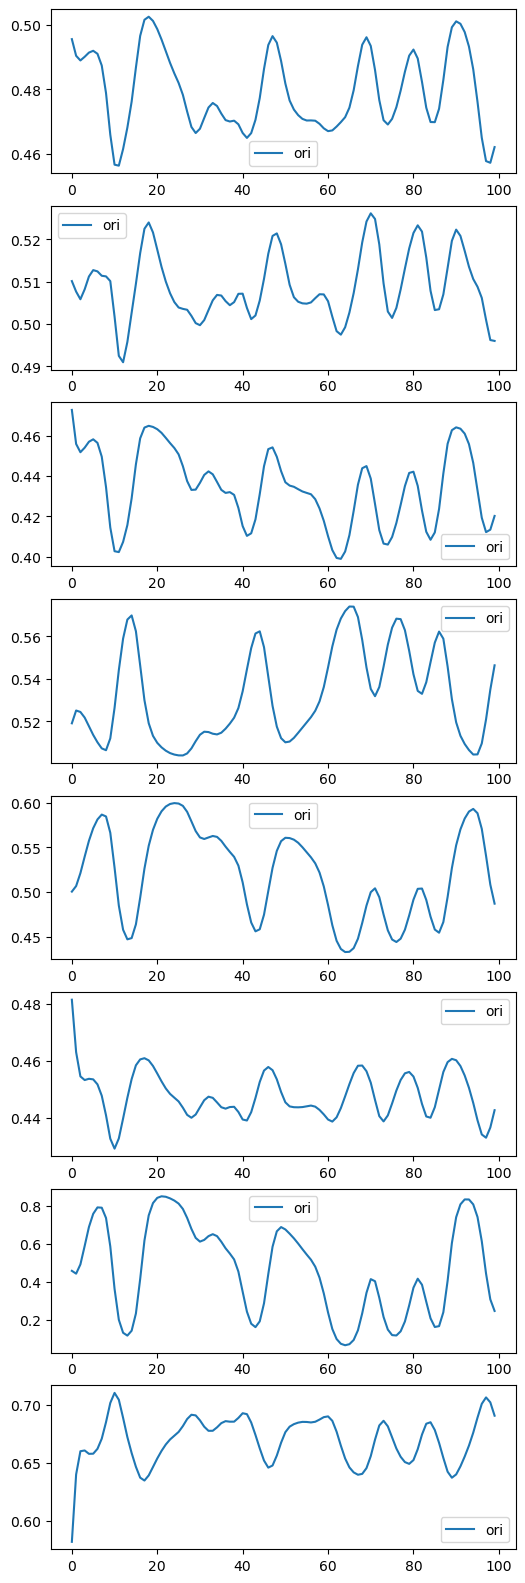

In [15]:
x_new = new_sample[0]
print(x_new.shape, type(x_new), len(new_sample))
fig = plt.figure(figsize=(6, 20))
for i in range(0, x_new.shape[1]):
    plt.subplot(8, 1, i+1)
    plt.plot(x_new[x_new.columns[i]], label='ori')
    plt.legend()
print(x_new.shape)

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

idx = np.random.permutation(len(new_sample))[:n]

# convert the list of synthetic/original samples to array (n, 100, 8)
true_positive_samples = np.asarray(true_positive_samples)
synthetic_samples = np.asanyarray(new_sample)[idx]

# For the purpose of comparison we need the data to be 2-dimensional
# For that reason we are going to use only two components for both the PCA and tSNE
# reduced shape: (n*100, 8)
reduced_true_positive_samples = true_positive_samples.reshape(-1, 8)
reduced_synthetic_samples = synthetic_samples.reshape(-1, 8)

# reduce the dimensionality to 2 dimensions
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

# fit the data using the true positive samples
pca.fit(reduced_true_positive_samples)

# transform the data
# pca_data: (n*100, 2)
pca_true_positive_samples = pd.DataFrame(pca.transform(reduced_true_positive_samples))
pca_synthetic_samples = pd.DataFrame(pca.transform(reduced_synthetic_samples))

# combine reduced data (2n*100, 8) 
combine_reduced = np.concatenate((reduced_true_positive_samples, reduced_synthetic_samples))

# tsne results (n*100, 2)
tsne_results = pd.DataFrame(tsne.fit_transform(combine_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

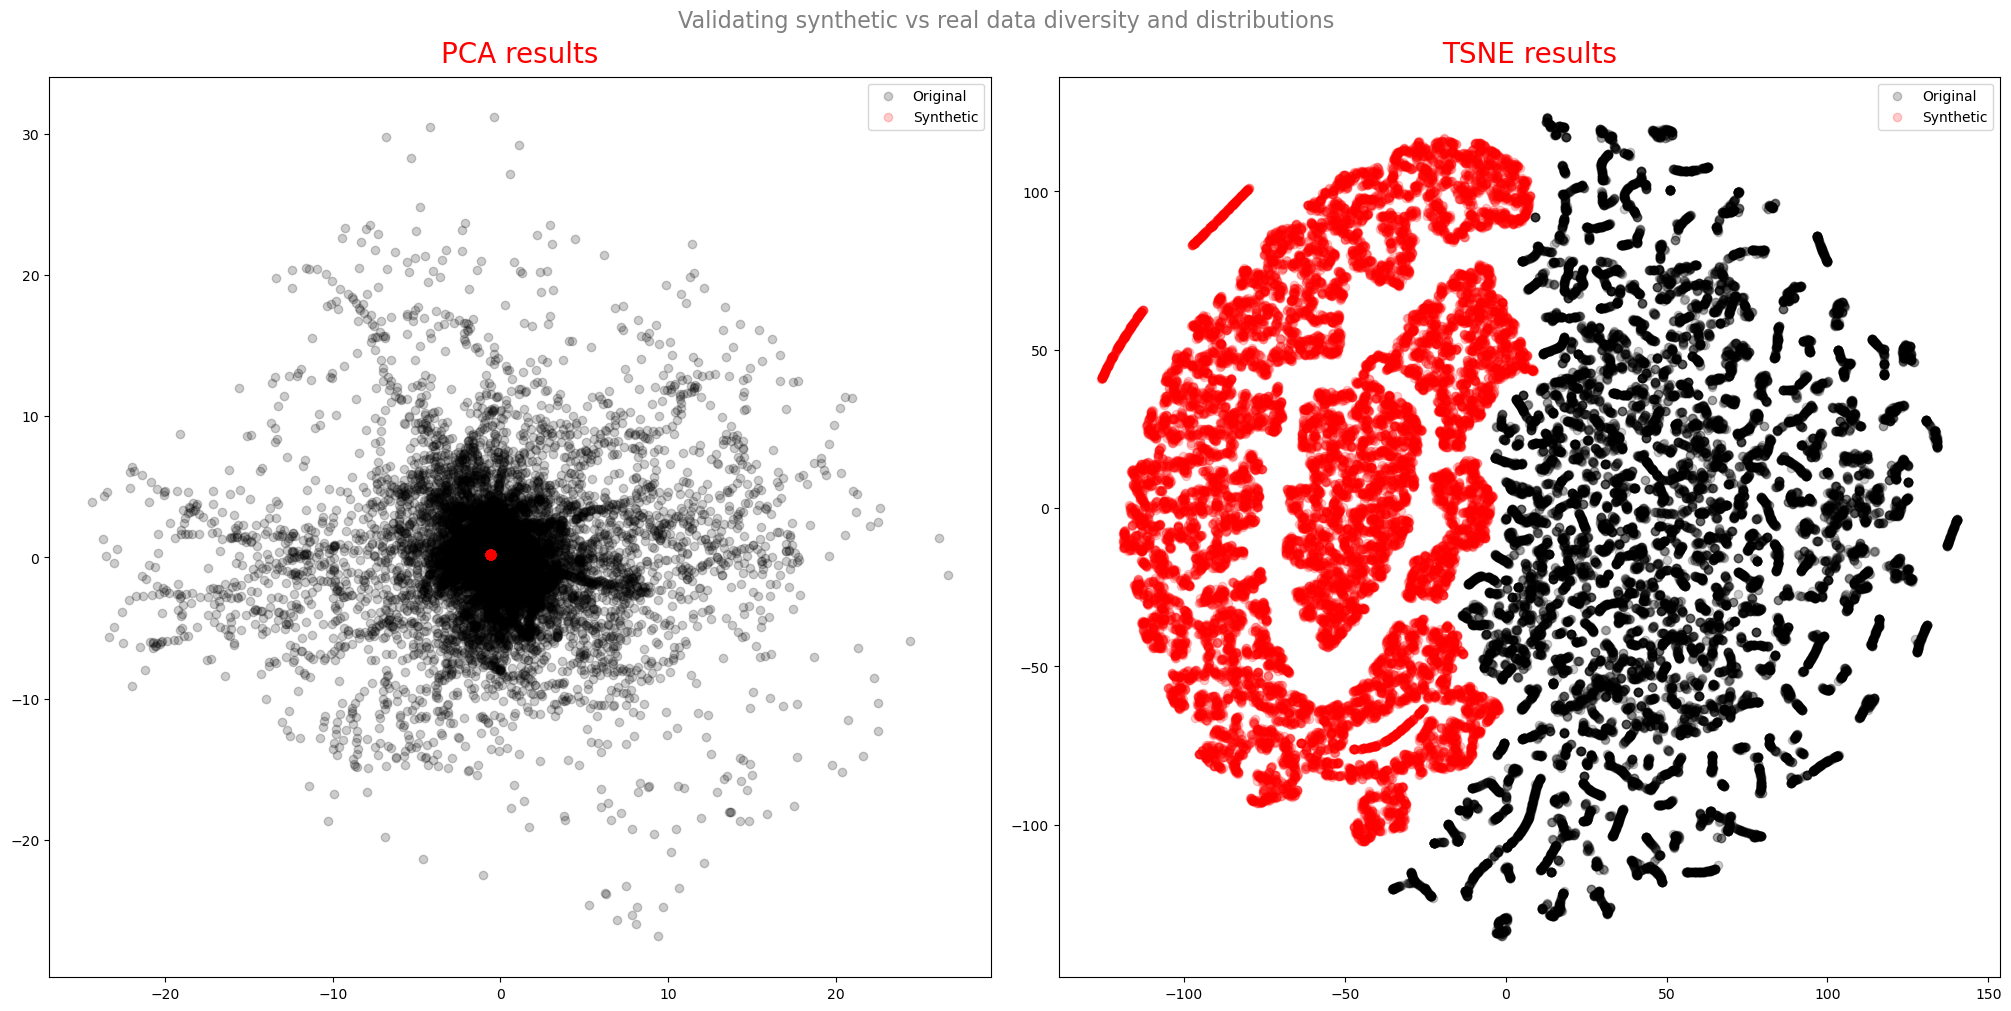

In [17]:
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=(20, 10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])
ax.set_title('PCA results', fontsize=20, color='red', pad=10)
plt.scatter(pca_true_positive_samples.iloc[:, 0].values,
            pca_true_positive_samples.iloc[:, 1].values,
            c='k',
            alpha=0.2,
            label='Original')
plt.scatter(pca_synthetic_samples.iloc[:, 0].values,
            pca_synthetic_samples.iloc[:, 1].values,
            c='r',
            alpha=0.2,
            label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0, 1])
ax2.set_title('TSNE results', fontsize=20, color='red', pad=10)
plt.scatter(tsne_results.iloc[:n*100, 0].values,
            tsne_results.iloc[:n*100, 1].values,
            c='k',
            alpha=0.2,
            label='Original')
plt.scatter(tsne_results.iloc[n*100:, 0].values,
            tsne_results.iloc[n*100:, 1].values,
            c='r',
            alpha=0.2,
            label='Synthetic')
ax2.legend()

plt.suptitle('Validating synthetic vs real data diversity and distributions', fontsize=16, color='grey')